In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy import interpolate
import os
import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.font_manager as fm
import tabulate
import matplotlib
import scipy.stats
import networkx as nx
import itertools
from sklearn import metrics
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import radius_neighbors_graph
import matplotlib.patches as mpatches
import sklearn.neighbors
from scipy.spatial import distance
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from mpl_toolkits.axes_grid1 import ImageGrid
from collections import Counter
import skimage
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
import io
import numpy as np
import gget
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from skimage.color import rgb2hed, hed2rgb

import sys
sys.path.append("../")
import utils as ut

from mpl_toolkits.mplot3d import Axes3D

In [2]:
# upload the scale factors

keys = ['ND', 'HFD8', 'HFD14']

scales = []

for key in keys:
    path = f"/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/{key}/outs/spatial/scalefactors_json.json"
    
    tmp = pd.read_json(path, lines=True)
    tmp['key'] = key
    # tmp['lowres_spot_diameter_pixels'] = tmp['spot_diameter_fullres'] * tmp['tissue_lowres_scalef']
    # tmp['lowres_spot_diameter_units'] = tmp['lowres_spot_diameter_pixels'] * 65
    
    scales.append(tmp)
    
scales = pd.concat(scales, ignore_index=True)
print(scales)
# print(scales[['key', 'spot_diameter_fullres', 'lowres_spot_diameter_pixels']])



def getscalebar(key, length, scales=scales):
    """Length is physical units """
    lookup = scales.loc[scales['key'] == key]
    pixels = lookup['spot_diameter_fullres'].values[0]
    scaleFactor = lookup['tissue_hires_scalef'].values[0]
    units = 55 # mircons
    fullResPixels = (pixels * length) / units
    lowResPixels = fullResPixels * scaleFactor
    return lowResPixels

def transScaleBar(hiresX, ultrahiresX, lowResPixels):
    """A function to resize the scale bar based on the 
    ultra hir-res image shape """
    newPixels = (lowResPixels * ultrahiresX) / hiresX
    return newPixels

getscalebar('ND', length=100)

   spot_diameter_fullres  tissue_hires_scalef  fiducial_diameter_fullres   
0             257.195160             0.050684                 415.469120  \
1             257.368127             0.051089                 415.748513   
2             257.404844             0.049124                 415.807825   

   tissue_lowres_scalef    key  
0              0.015205     ND  
1              0.015327   HFD8  
2              0.014737  HFD14  


23.701345795450475

In [3]:
cardOutDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDOuputs/"

dfList = []

for f in os.listdir(cardOutDir):
    if 'global' in f:
        fullPath = f"{cardOutDir}{f}"
        key = f.split("_")[0]
        df = pd.read_csv(fullPath)
        df = df.rename(columns={'Unnamed: 0' : 'spotId'})
        df['key'] = key
        dfList.append(df)

df = pd.concat(dfList, ignore_index=True)
print(f"{df.shape=}")
print(df['key'].value_counts())
print()
df.head()

df.shape=(7418, 13)
key
HFD8     3391
ND       2034
HFD14    1993
Name: count, dtype: int64



,spotId,B cells,Mac1,Mac3,Monocytes,T cells,NK cells,Stromal cells,Dendritic cells,Mac4,Mac2,Mac5,key
0,AAACAAGTATCTCCCA.1_ND,0.018691,0.009410,0.010737,0.070782,0.040298,0.077389,0.645332,0.015281,0.045516,0.039354,0.027211,ND
1,AAACAGCTTTCAGAAG.1_ND,0.008378,0.005700,0.038038,0.089932,0.048618,0.103983,0.575021,0.046758,0.020027,0.035451,0.028094,ND
2,AAACAGGGTCTATATT.1_ND,0.024325,0.010761,0.024323,0.117606,0.072993,0.121093,0.478383,0.026608,0.042051,0.048258,0.033598,ND
3,AAACATTTCCCGGATT.1_ND,0.023002,0.014704,0.044181,0.087019,0.053537,0.083922,0.465958,0.053223,0.087758,0.037452,0.049242,ND
4,AAACCCGAACGAAATC.1_ND,0.021954,0.003784,0.001240,0.038020,0.026386,0.061364,0.775170,0.003725,0.023106,0.025914,0.019336,ND


In [4]:
sptDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

spt = {}

for f in os.listdir(sptDir):
    if "spt" in f and "global" in f:
        fullPath = f"{sptDir}{f}"
        key = f.split("_")[0]
        sdf = pd.read_csv(fullPath)
        sdf = sdf.rename(columns={'Unnamed: 0' : 'gene'})
        sdf = sdf.set_index('gene')
        sdf = sdf.T
        sdf.index = sdf.index.str.replace("-", ".")
        sdf = ut.normalize(sdf, 1e6)
        spt[key] = sdf
        print(f, sdf.shape)
    
print('done')

HFD8_global_spt.csv (3394, 31053)
ND_global_spt.csv (2036, 31053)
HFD14_global_spt.csv (1994, 31053)
done


In [5]:
coordDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

dfList = []

for f in os.listdir(coordDir):
    if "coord" in f and "global" in f:
        fullPath = f"{coordDir}{f}"
        key = f.split("_")[0]
        cdf = pd.read_csv(fullPath)
        cdf = cdf.rename(columns={'Unnamed: 0' : 'spotId'})
        cdf['key'] = key
        dfList.append(cdf)

cdf = pd.concat(dfList, ignore_index=True)
print(f"{cdf.shape=}")
print(cdf['key'].value_counts())
print()
cdf.head()

cdf.shape=(7424, 4)
key
HFD8     3394
ND       2036
HFD14    1994
Name: count, dtype: int64



,spotId,x,y,key
0,AAACAAGTATCTCCCA.1_HFD8,1244.795278,1189.669724,HFD8
1,AAACACCAATAACTGC.1_HFD8,405.548324,1349.579809,HFD8
2,AAACAGCTTTCAGAAG.1_HFD8,303.880251,1068.178931,HFD8
3,AAACAGGGTCTATATT.1_HFD8,344.496391,1138.478061,HFD8
4,AAACAGTGTTCCTGGG.1_HFD8,648.734268,1595.524585,HFD8


In [6]:
"""Merge CARD predictions with spatial coordinates"""
df = pd.merge(cdf, df,
              how='left', 
              left_on=['spotId', 'key'],
              right_on=['spotId', 'key'])

df = df.fillna(0)
df = df.drop_duplicates() # very important!
print(df['key'].value_counts())
df.head()

key
HFD8     3394
ND       2036
HFD14    1994
Name: count, dtype: int64


,spotId,x,y,key,B cells,Mac1,Mac3,Monocytes,T cells,NK cells,Stromal cells,Dendritic cells,Mac4,Mac2,Mac5
0,AAACAAGTATCTCCCA.1_HFD8,1244.795278,1189.669724,HFD8,0.077635,0.022735,0.104811,0.111453,0.125867,0.195064,0.059765,0.111978,0.082445,0.066571,0.041676
1,AAACACCAATAACTGC.1_HFD8,405.548324,1349.579809,HFD8,0.076987,0.041831,0.047343,0.139484,0.082711,0.093085,0.148247,0.071763,0.058744,0.142045,0.097760
2,AAACAGCTTTCAGAAG.1_HFD8,303.880251,1068.178931,HFD8,0.079216,0.043327,0.075868,0.086821,0.086695,0.097747,0.186142,0.090520,0.069670,0.094246,0.089748
3,AAACAGGGTCTATATT.1_HFD8,344.496391,1138.478061,HFD8,0.037682,0.029618,0.093281,0.109521,0.052151,0.061401,0.201332,0.094533,0.143671,0.088173,0.088637
4,AAACAGTGTTCCTGGG.1_HFD8,648.734268,1595.524585,HFD8,0.092691,0.001555,0.002745,0.075636,0.054631,0.052849,0.112912,0.008552,0.258918,0.056771,0.282740


In [7]:
def closest_node(node, nodes, metric):
    closest_index = distance.cdist([node], nodes, metric=metric).argmin()
    return closest_index

def getSubGraph(kdf, x, y, metric='minkowski', return_center=True):
    """A function to generate a graph of size n x n
    around point (x, y) """
    
    nodes = kdf[['x', 'y']]
    centerInd = closest_node([x, y], nodes, metric)
    
      
    # get the n points around that node
    nbrs = NearestNeighbors(n_neighbors=n,  
                            metric=metric, 
                            algorithm='ball_tree').fit(nodes)
    distances, indices = nbrs.kneighbors(nodes)
    
    # create the subgraph
    windowIndices = indices[centerInd]
    mask = kdf.index.isin(windowIndices)
    
    center = kdf[mask].reset_index(drop=True)
    dists = sklearn.metrics.pairwise_distances(center[['x', 'y']], metric=metric)
    
    X = dists
    
    # create the graph
    nodeMapper = dict(zip(center.index, center['spotId']))
    G = nx.from_numpy_array(X)
    G = nx.relabel_nodes(G, nodeMapper)
    
    # set positions
    pos = {}
    for idx, row in center.iterrows():
        pos[row['spotId']] = np.array(row[['x', 'y']])
    
    G.pos = pos
    
    if return_center:
        return G, center
    else:
        return G
    
    
def getFullGraph(kdf, metric='minkowski'):
    """A function to generate a graph of size n x n
    around point (x, y) """
    
    nodes = kdf[['x', 'y']]

    dists = sklearn.metrics.pairwise_distances(nodes, metric=metric)
    np.fill_diagonal(dists, 0) # no self loops!
    X = dists
    
    # create the graph
    nodeMapper = dict(zip(kdf.index, kdf['spotId']))
    G = nx.from_numpy_array(X)
    G = nx.relabel_nodes(G, nodeMapper)
    
    # set positions
    pos = {}
    for idx, row in kdf.iterrows():
        pos[row['spotId']] = np.array(row[['x', 'y']])
    
    G.pos = pos
    return G
    
    
def getKnn(kdf, k=6, metric='minkowski'):
    """A function to generate a knn graph """
    
    nodes = kdf[['x', 'y']]
      
    # get the n points around that node
    nbrs = NearestNeighbors(n_neighbors=k+1,  
                            metric=metric, 
                            algorithm='ball_tree').fit(nodes)
    distances, indices = nbrs.kneighbors(nodes)
    return indices


def knnInd2Id(kdf, knnInd):
    """Translate neighbors to spotIds """
    
    transId = {}
    
    for i, row in kdf.iterrows():
        spotId = row['spotId']
        nbrhs = kdf.iloc[knnInd[i]]['spotId'].values
        transId[spotId] = nbrhs
    return transId
    
    

def blur(sdf, transId):
    """A function to blur all columns using their neighbors.
    Expects spotIds as index """
    
    results  = []
    
    for spotId, nbhs in transId.items():
        
        # make sure the spot is present
        if spotId in sdf.index:
            nbhs = [x for x in nbhs if x in sdf.index]
            
            t = sdf.loc[nbhs].mean().to_dict()
            t['spotId'] = spotId
            results.append(t)
        
    results = pd.DataFrame(results)
    results = results.set_index('spotId')
    return results


def getCentralities(G):
    """ function to compute centralities """
    cf = pd.DataFrame({'spotId' : G.nodes()})
    cf['degree_centrality'] = cf['spotId'].map(nx.degree_centrality(G))
    cf['betweenness_centrality'] = cf['spotId'].map(nx.betweenness_centrality(G))
    # cf['closeness_centrality'] = cf['spotId'].map(nx.closeness_centrality(G))
    # cf['harmonic_centrality'] = cf['spotId'].map(nx.harmonic_centrality(G))
    cf['eigenvector_centrality'] = cf['spotId'].map(nx.eigenvector_centrality(G, tol=0.001))
    return cf


def prune(G, weight, threshold, min_components):
    """A function to prune disconnected components """
    H = nx.Graph(((u, v, e) for u,v,e in G.edges(data=True) if e[weight] < threshold))
    H.pos = G.pos
    
    for component in list(nx.connected_components(H)):
        if len(component) < min_components:
            for node in component:
                H.remove_node(node)
    return H



    
def removeDisconnectedNodes(G, radius=25, min_edges=3):
    """A function to remove spots that are not nearby
    other spots """
    H = G.copy()
    H.pos = G.pos
    
    H.remove_edges_from([(n1, n2) for n1, n2, w in H.edges(data="weight") if w > radius])
    degree = pd.DataFrame(nx.degree(H), columns=['node', 'degree'])
    
    mask = (degree['degree'] > min_edges)
    dropNodes = degree[~mask]
    
    # drop the nodes
    H.remove_nodes_from(dropNodes['node'].to_list())
    
    return H

In [8]:
# load the gene counts

q = 0.05
counts = pd.read_csv("../spatial/spt_counts.csv")

dropSpots = []

for key in keys:

    t_counts = counts[counts['key_x'] == key]
    thresh = np.quantile(t_counts['read_count'], q)
    spots2Drop = t_counts[t_counts['read_count'] < thresh]['spotId'].to_list()
    dropSpots += spots2Drop

    print(key, thresh)

counts.head()

ND 44.0
HFD8 38.0
HFD14 70.0


,spotId,read_count,gene_count,x,y,key_x,B cells,Mac1,Mac3,Monocytes,T cells,NK cells,Stromal cells,Dendritic cells,Mac4,Mac2,Mac5,key_y
0,AAACAAGTATCTCCCA.1_ND,214.0,109,1263.912793,1164.571691,ND,0.018691,0.009410,0.010737,0.070782,0.040298,0.077389,0.645332,0.015281,0.045516,0.039354,0.027211,ND
1,AAACAGCTTTCAGAAG.1_ND,104.0,69,331.221482,1043.233630,ND,0.008378,0.005700,0.038038,0.089932,0.048618,0.103983,0.575021,0.046758,0.020027,0.035451,0.028094,ND
2,AAACAGGGTCTATATT.1_ND,228.0,105,371.414081,1112.975138,ND,0.024325,0.010761,0.024323,0.117606,0.072993,0.121093,0.478383,0.026608,0.042051,0.048258,0.033598,ND
3,AAACATTTCCCGGATT.1_ND,231.0,135,1213.938136,1356.563577,ND,0.023002,0.014704,0.044181,0.087019,0.053537,0.083922,0.465958,0.053223,0.087758,0.037452,0.049242,ND
4,AAACCCGAACGAAATC.1_ND,214.0,91,1394.171280,1077.242752,ND,0.021954,0.003784,0.001240,0.038020,0.026386,0.061364,0.775170,0.003725,0.023106,0.025914,0.019336,ND


In [9]:
keys = ['ND', 'HFD8', 'HFD14']
graph = {}
min_components = 3 # remove disconnected nodes


"""
NOTE: here we remove edges that are greater distance than the nearest neighbor
""" 
    
for i, key in enumerate(keys):
    kdf = df[df['key'] == key].reset_index(drop=True)

    # drop low count spots
    kdf = kdf[~kdf['spotId'].isin(dropSpots)].reset_index()
    
    G = getFullGraph(kdf)
    G = removeDisconnectedNodes(G)
    graph[key] = G
    
print('done')

done


In [10]:
cTypes = [
    'Dendritic cells', 
    'Mac4',
    'Stromal cells',
    'NK cells', 
    'Mac2', 
    'Monocytes',
    'T cells',
    'Mac5',
    'Mac3',
    'Mac1',
    'B cells',
]

In [11]:
# break

In [12]:
"""Build the graph"""

allGraphs = {}
radius = 25

for i, key in enumerate(keys):
    
    kdf = df[df['key'] == key].reset_index(drop=True)

    # drop low count spots
    kdf = kdf[~kdf['spotId'].isin(dropSpots)].reset_index()

    
    G = graph[key]
    
    normedCols = {}
    for ctype in cTypes:
        newCol = f"{ctype} norm"
        normedCols[newCol] = ctype
        kdf[newCol] = kdf[ctype] / kdf[ctype].max()


    # print(kdf.columns)
    node_attr = kdf.set_index('spotId').to_dict('index')
    nx.set_node_attributes(G, node_attr)    
    
    edgelists = {}
    for u,v,e in G.edges(data=True):        
        if e['weight'] < radius:
            
            for norm, ctype in normedCols.items():
                if norm in G.nodes[u].keys():
                    x1 = G.nodes[u][norm]
                if norm in G.nodes[v].keys():
                    x2 = G.nodes[v][norm]

                else:
                    x1 = 0
                    x2 = 0
                
                w = scipy.stats.hmean([x1, x2])
                edge = (u,v, w)
                
                if ctype in edgelists.keys():
                    edgelists[ctype].append(edge)
                else:
                    edgelists[ctype] = [edge]
                
    """ create the subgraph """
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    
    for ctype in cTypes:
        edges = edgelists[ctype]
        H.add_weighted_edges_from(edges, weight=ctype)
    H.pos = G.pos
    nx.set_node_attributes(H, node_attr)  
    allGraphs[key] = H
    
print('done')

done


# Image Classifcation

In [13]:
imDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/images/lowres/"

lowres = {}
for f in os.listdir(imDir):
    if f.endswith("png"):
        fullpath = f"{imDir}{f}"
        img = skimage.io.imread(fullpath, as_gray=True)
        key = f.replace(".png", "")
        print(key, img.shape)
        lowres[key] = img

print('done')

HFD14 (2000, 1628)
ND (2000, 1681)
HFD8 (2000, 1692)
done


In [14]:
img = lowres['HFD14']

nClasses = 4
thresholds = skimage.filters.threshold_multiotsu(img, classes=nClasses)

# Using the threshold values, we generate the region
regions = np.digitize(img, bins=thresholds)
# training_labels = np.where((regions == 0) | (regions == 1), 1, regions) 
training_labels = regions + 1

sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True,
                        edges=False, 
                        texture=True,
                        sigma_min=sigma_min,
                        sigma_max=sigma_max)
                        # channel_axis=-1)

features = features_func(img)

clf = RandomForestClassifier(n_estimators=50,
                             n_jobs=-1,
                             max_depth=10, 
                             max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

### run the random forest on all images
segment = {}

for i, key in enumerate(keys):
    img = lowres[key]
    features = features_func(img)
    result = future.predict_segmenter(features, clf)
    segment[key] = result
    
    
print('done')

done


# Quantify Tissue 

In [15]:
microns = 150

res = []

for key in keys:
    
    # get window size based on physical units
    img = lowres[key]
    pixelsPerMicron = getscalebar(key, 1)
    ws = int((microns * pixelsPerMicron) / 2)
    
    
    print(f"{microns=} {pixelsPerMicron=:.3f} {ws=}")
    
    kdf = df[df['key'] == key].reset_index(drop=True)

    # drop low count spots
    kdf = kdf[~kdf['spotId'].isin(dropSpots)].reset_index()
    
    # fillImg = hires[key]
    fillImg = lowres[key]
    
    for idx, row in kdf.iterrows():
        # get coordinates
        x = int(row['x'])
        y = int(row['y'])
        xLb = int(x) - ws
        xUb = int(x) + ws   
        yLb = int(y) - ws   
        yUb = int(y) + ws
        
        # predict on window
        window = segment[key][yLb:yUb, xLb:xUb]
        
        # store results
        newRow = {}       
        for k, v in Counter(window.ravel()).items():
            newRow[k] = v / window.size
        
        newRow['key'] = key
        newRow['spotId'] = row['spotId']
        res.append(newRow)

res = pd.DataFrame(res)
res = res.fillna(0)
res.head()

microns=150 pixelsPerMicron=0.237 ws=17
microns=150 pixelsPerMicron=0.239 ws=17
microns=150 pixelsPerMicron=0.230 ws=17


,4,3,2,1,key,spotId
0,0.770761,0.164360,0.057958,0.006920,ND,AAACAAGTATCTCCCA.1_ND
1,0.832180,0.113322,0.048443,0.006055,ND,AAACAGCTTTCAGAAG.1_ND
2,0.891869,0.086505,0.019031,0.002595,ND,AAACAGGGTCTATATT.1_ND
3,0.621972,0.257785,0.105536,0.014706,ND,AAACATTTCCCGGATT.1_ND
4,0.891869,0.076990,0.022491,0.008651,ND,AAACCCGAACGAAATC.1_ND


In [16]:
# """ Add tissue predictions to graphs """

# labelMap = {
#     1 : r"CLS_${hi}$",
#     2 : r"CLS_${mid}$",
#     3 : r"Background",
#     4 : r"Adipocyte",
# }


# for key in keys:
#     G = allGraphs[key].copy()
    
#     segDf = res[res['key'] == key][[1, 2, 3, 4, 'spotId']]
#     # segDf = segDf.rename(columns=labelMap)
#     # print(segDf.head())
    
#     node_attr = segDf.set_index('spotId').to_dict('index')
#     # print(node_attr)
#     nx.set_node_attributes(G, node_attr)    
#     allGraphs[key] = G
    
# print('done')

# plot segementations

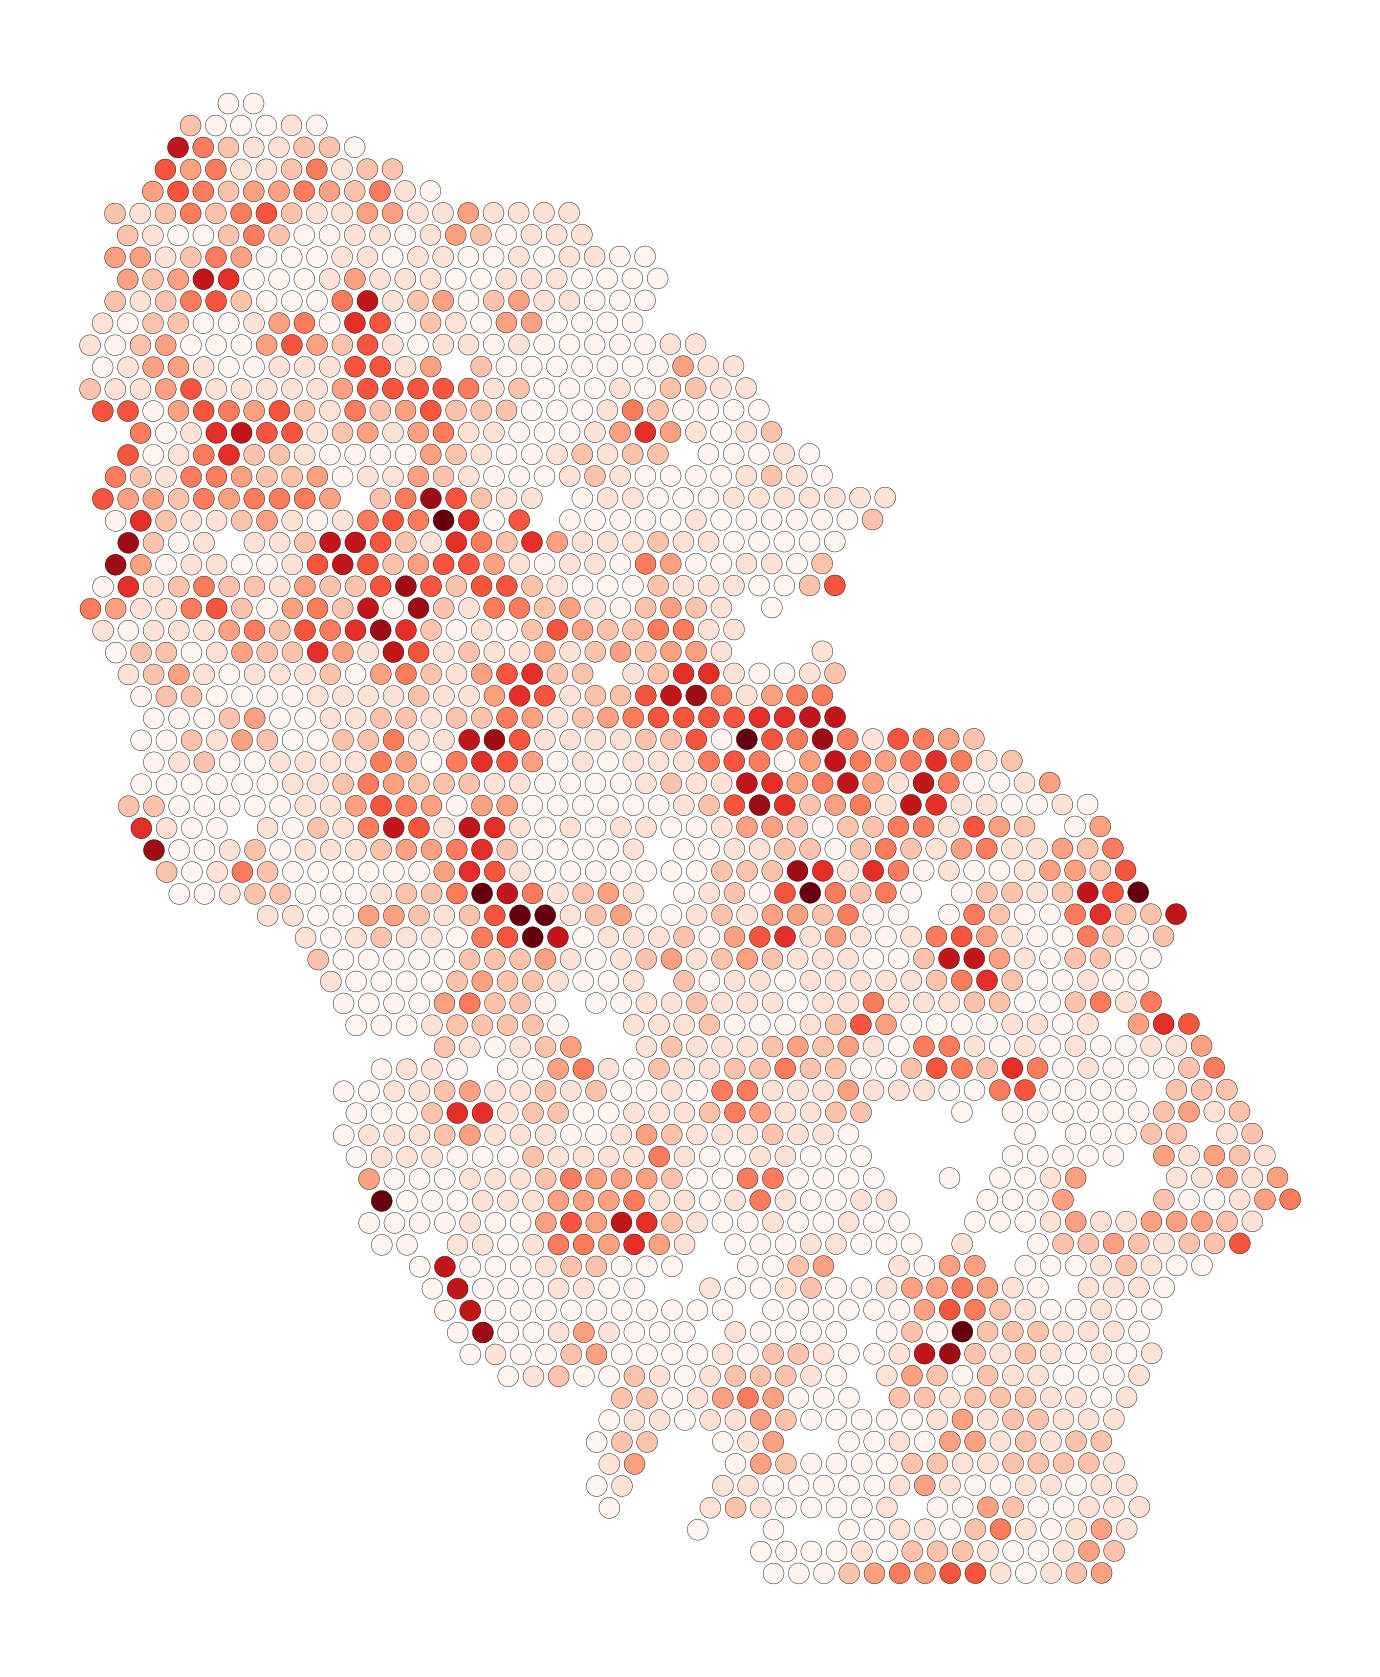

In [17]:
key = 'HFD14'
plotLabel = 1
nodeSize = 25
cmap = plt.cm.get_cmap('Reds', lut=10)
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['cyan','w'])
G = allGraphs[key] # get the graph

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "None"
plt.rcParams['figure.figsize'] = 12, 7

fig, axs = plt.subplots()

pdf = res[res['key'] == key][[1, 2, 3, 4, 'spotId']]

# drop low count spots
pdf = pdf[~pdf['spotId'].isin(dropSpots)]

pdf[plotLabel] = np.where(pdf[plotLabel] > np.quantile(pdf[plotLabel], 0.99), 0, pdf[plotLabel])


node_attr = pdf.set_index('spotId').to_dict('index')


colors = []
nodes = []

for n in G.nodes():
    if n in node_attr.keys():
        colors.append(node_attr[n][plotLabel])
        nodes.append(n)

# colors = [node_attr[n]
        # [plotLabel] for n in G.nodes() if n in node_attr.keys()]

colors = sklearn.preprocessing.scale(colors)
colors = sklearn.preprocessing.minmax_scale(colors, feature_range=(0, 1))

# print(pdf.shape, len(colors))

nx.draw_networkx_nodes(G,
                       pos=G.pos,
                       node_size=nodeSize, 
                       node_color=colors,
                       edgecolors='k',
                       alpha=1,
                       cmap=cmap,
                       linewidths=0.1,
                       ax=axs)

# format the axis
axs.set_aspect('equal')
# axs[i].set_title(ct)
axs.invert_yaxis()
axs.set_facecolor('None')
sns.despine(left=True, bottom=True)

In [18]:
# break

In [19]:
key = 'HFD8'
G = allGraphs[key]


segLabels = res[res['key'] == key][[1, 2, 3, 4, 'spotId']]

pdf = []

for node in G.nodes(data=True):
    nData = node[1]
    nData['spotId'] = node[0]
    pdf.append(nData)
    

pdf = pd.DataFrame(pdf)

# megre segementations
pdf = pd.merge(pdf, segLabels,
               how='left',
               left_on='spotId',
               right_on='spotId',)



outdir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/FIG6/"
fname = "segmentation_8w.csv"
pdf.to_csv(f"{outdir}{fname}", index=False)
pdf.head()

,index,x,y,key,B cells,Mac1,Mac3,Monocytes,T cells,NK cells,...,T cells norm,Mac5 norm,Mac3 norm,Mac1 norm,B cells norm,spotId,1,2,3,4
0,1,405.548324,1349.579809,HFD8,0.076987,0.041831,0.047343,0.139484,0.082711,0.093085,...,0.460504,0.134586,0.288651,0.083224,0.355278,AAACACCAATAACTGC.1_HFD8,0.006055,0.024221,0.036332,0.933391
1,2,303.880251,1068.178931,HFD8,0.079216,0.043327,0.075868,0.086821,0.086695,0.097747,...,0.482684,0.123556,0.462571,0.086201,0.365567,AAACAGCTTTCAGAAG.1_HFD8,0.031142,0.062284,0.154844,0.751730
2,3,344.496391,1138.478061,HFD8,0.037682,0.029618,0.093281,0.109521,0.052151,0.061401,...,0.290354,0.122026,0.568738,0.058926,0.173895,AAACAGGGTCTATATT.1_HFD8,0.043253,0.042388,0.087370,0.826990
3,4,648.734268,1595.524585,HFD8,0.092691,0.001555,0.002745,0.075636,0.054631,0.052849,...,0.304165,0.389248,0.016739,0.003093,0.427749,AAACAGTGTTCCTGGG.1_HFD8,0.000000,0.004325,0.040657,0.955017
4,6,1194.574315,1383.349958,HFD8,0.049319,0.036883,0.087030,0.159997,0.039928,0.079121,...,0.222302,0.242415,0.530626,0.073379,0.227598,AAACATTTCCCGGATT.1_HFD8,0.000865,0.011246,0.062284,0.925606


In [20]:
pdf = res[res['key'] == key][[1, 2, 3, 4, 'spotId']]
pdf.head()

,1,2,3,4,spotId
1939,0.002595,0.013841,0.021626,0.961938,AAACAAGTATCTCCCA.1_HFD8
1940,0.006055,0.024221,0.036332,0.933391,AAACACCAATAACTGC.1_HFD8
1941,0.031142,0.062284,0.154844,0.751730,AAACAGCTTTCAGAAG.1_HFD8
1942,0.043253,0.042388,0.087370,0.826990,AAACAGGGTCTATATT.1_HFD8
1943,0.000000,0.004325,0.040657,0.955017,AAACAGTGTTCCTGGG.1_HFD8


In [21]:
# break

# Centrality

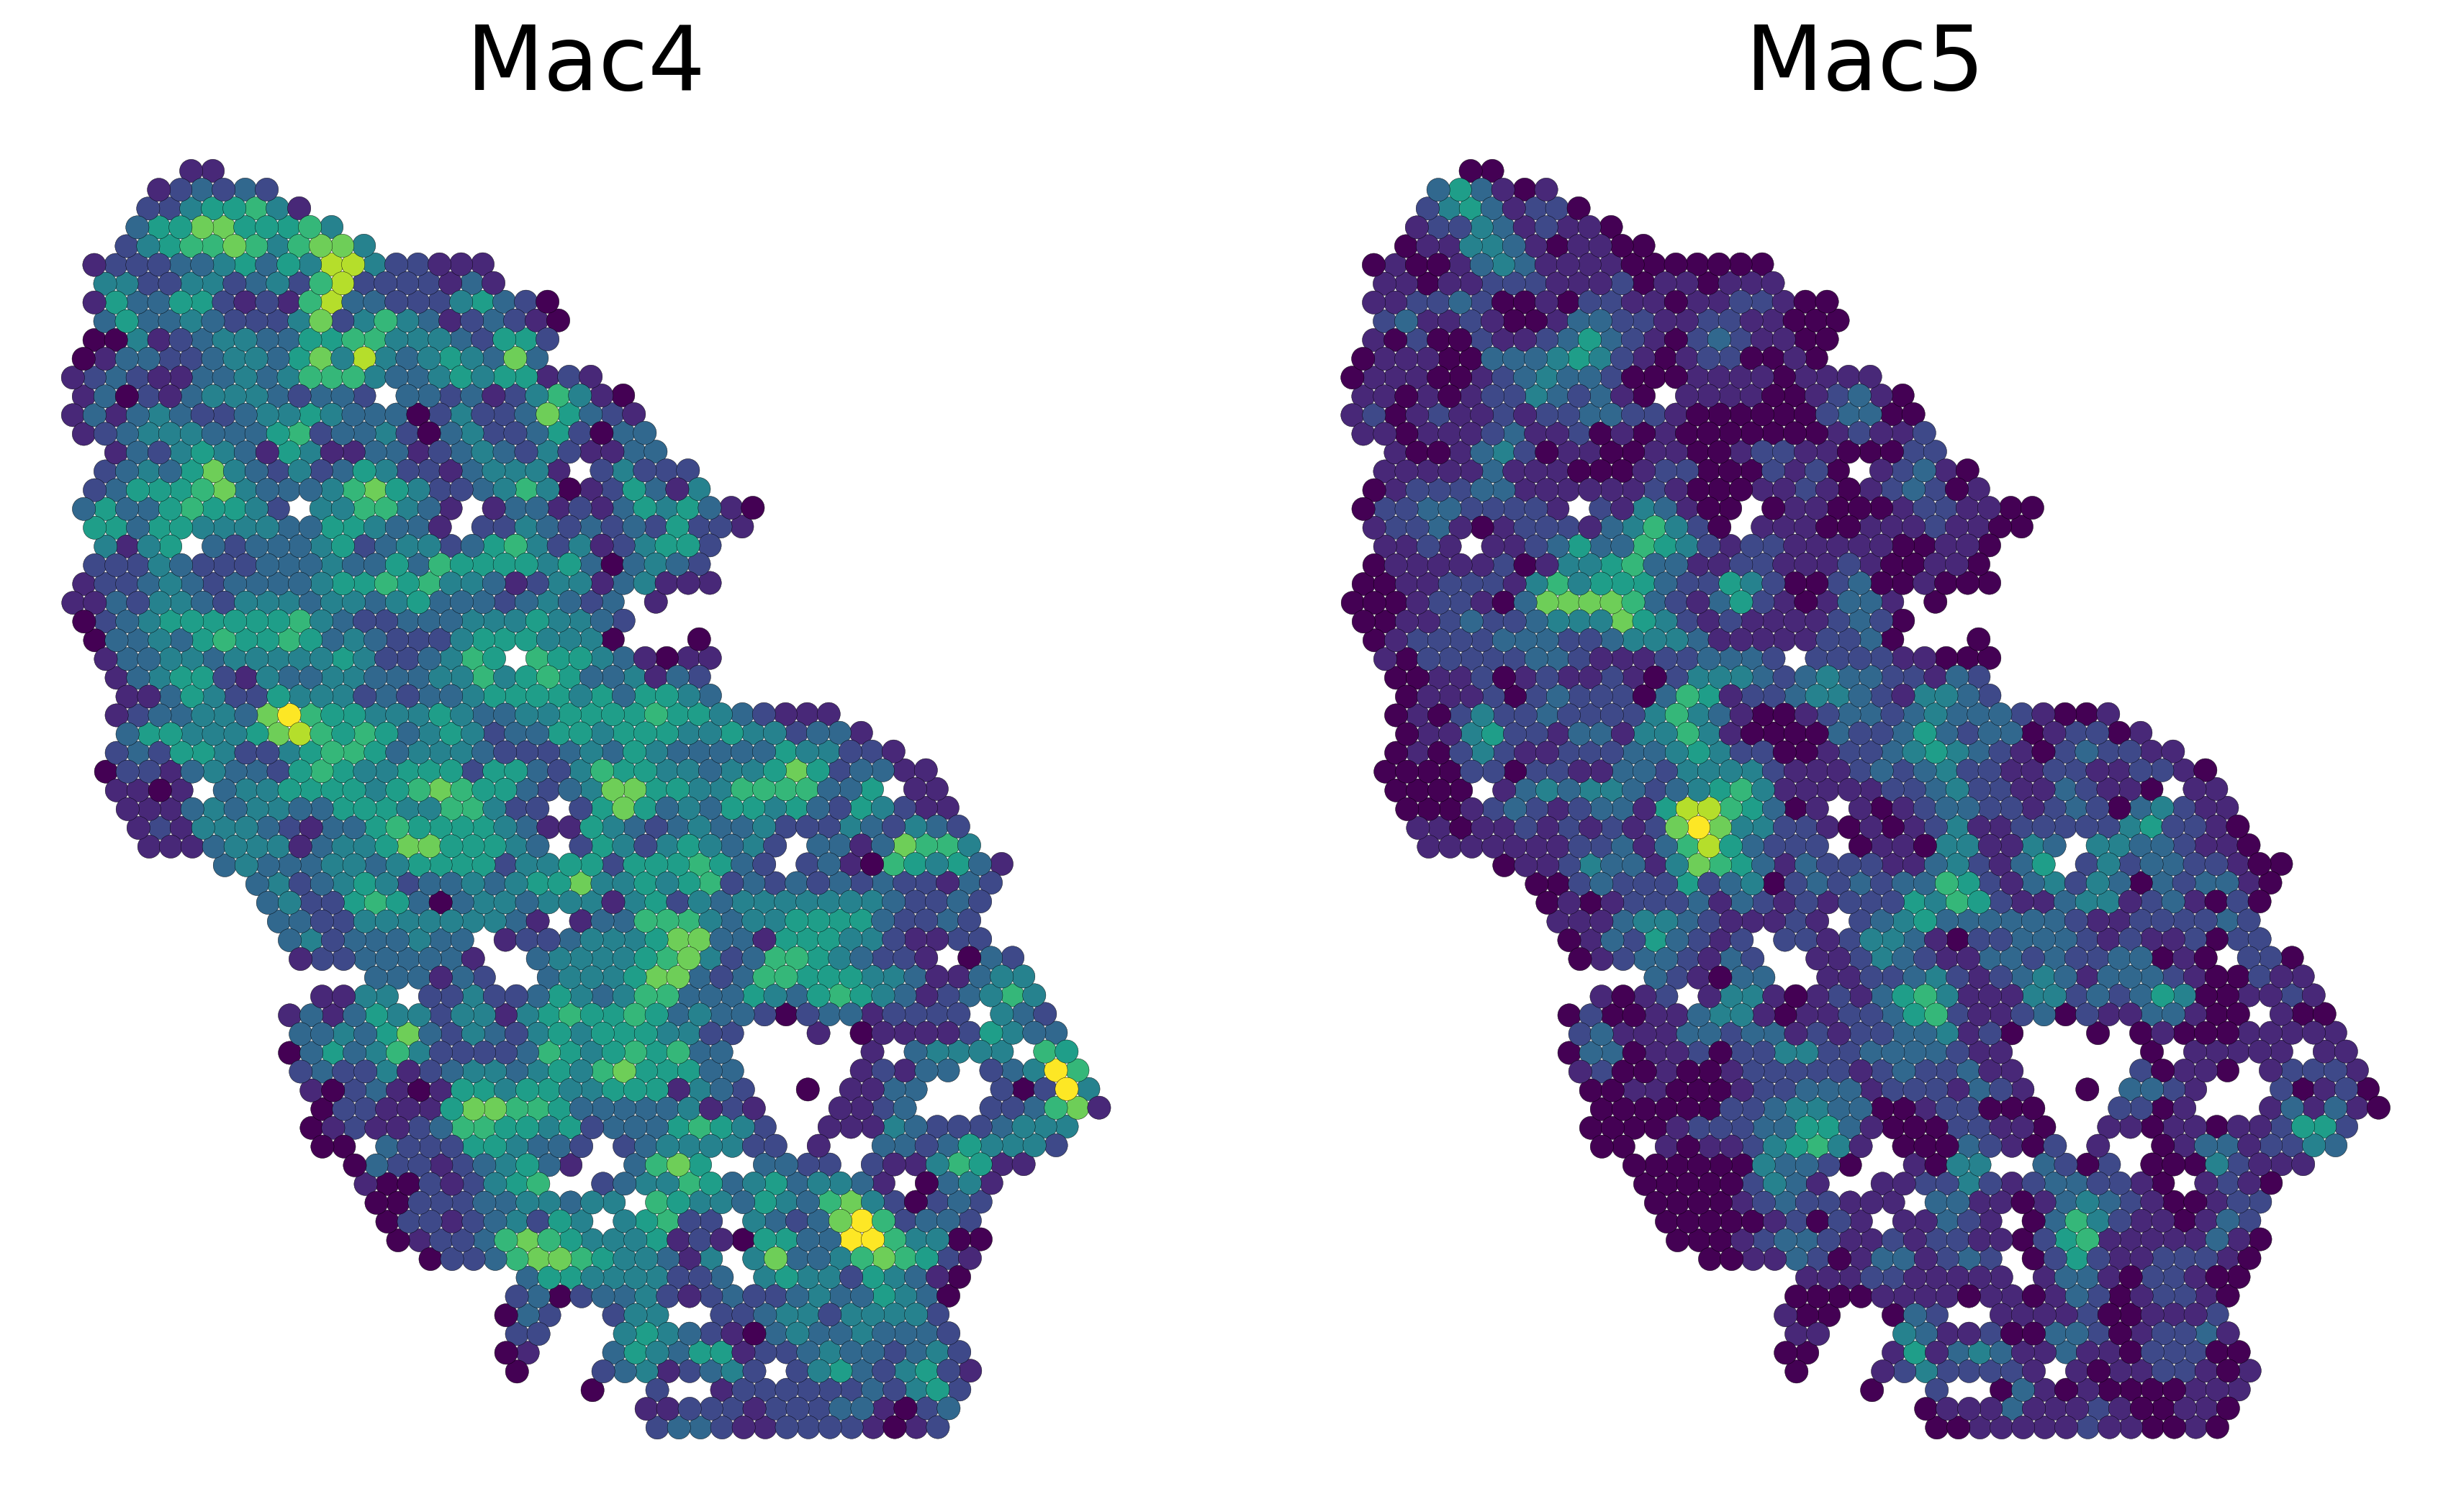

In [26]:
key = 'HFD14'
tol = 0.005
nodeSize = 60
cmap = plt.cm.get_cmap('plasma', lut=10)
G = allGraphs[key] # get the graph

ctypes = [
    # "Monocytes"
    "Mac4",
    "Mac5",
]

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}


"""
NETWORK PLOTS
"""

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 12, 7

fig, axs = plt.subplots(1, len(ctypes))
axs = axs.ravel()

centDf = []

for i, ct in enumerate(ctypes):
    
    centrality = nx.eigenvector_centrality(G, weight=ct, tol=tol)
    centDf.append(centrality)
    colors = [centrality[n] for n in G.nodes()]
    
    colors = sklearn.preprocessing.scale(colors)
    colors = sklearn.preprocessing.minmax_scale(colors, feature_range=(0, 1))
    
    nx.draw_networkx_nodes(G,
                           pos=G.pos,
                           node_size=nodeSize, 
                           node_color=colors,
                           edgecolors='k',
                           alpha=1,
                           cmap=plt.cm.get_cmap('viridis', lut=10),
                           linewidths=0.1,
                           ax=axs[i])
    
    # draw the edges
#     nx.draw_networkx_edges(G,
#                            pos=G.pos,
#                            width=1,
#                            edge_color='lightgrey',
#                            edge_cmap=cmap, 
#                            ax=axs[i])
    
    # format the axis
    axs[i].set_aspect('equal')
    axs[i].set_title(ct, fontsize=30)
    axs[i].invert_yaxis()
    # axs[i].set_facecolor('None')

plt.tight_layout()
sns.despine(left=True, bottom=True)

In [23]:
pdf = []

for key in ['HFD8', 'HFD14']:

    G = allGraphs[key]
    centrality = nx.eigenvector_centrality(G, weight=ct, tol=tol)

    tmp = pd.DataFrame(centrality.items())
    tmp.columns = ['spotId', 'centrality']
    tmp['key'] = key

    tmp['x'] = tmp['spotId'].apply(lambda x: G.pos[x][0])
    tmp['y'] = tmp['spotId'].apply(lambda x: G.pos[x][1])
    
    pdf.append(tmp)

pdf = pd.concat(pdf)


outdir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/FIG6/"
fname = "centralities.csv"
pdf.to_csv(f"{outdir}{fname}", index=False)
pdf.head()

,spotId,centrality,key,x,y
0,AAACACCAATAACTGC.1_HFD8,0.020936,HFD8,405.548324,1349.579809
1,AAACAGCTTTCAGAAG.1_HFD8,0.015519,HFD8,303.880251,1068.178931
2,AAACAGGGTCTATATT.1_HFD8,0.017590,HFD8,344.496391,1138.478061
3,AAACAGTGTTCCTGGG.1_HFD8,0.011487,HFD8,648.734268,1595.524585
4,AAACATTTCCCGGATT.1_HFD8,0.016577,HFD8,1194.574315,1383.349958


In [24]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Correlation

ND
HFD8
HFD14


,key,cellType,r,pval,sig,keyName
0,ND,B cells,-0.077079,8.751594e-04,*,ND
1,ND,Dendritic cells,0.091809,7.300282e-05,*,ND
2,ND,Mac1,-0.014582,5.295651e-01,,ND
3,ND,Mac2,-0.046381,4.544032e-02,,ND
4,ND,Mac3,0.079882,5.621535e-04,*,ND
5,ND,Mac4,0.005106,8.257795e-01,,ND
6,ND,Mac5,-0.015064,5.160446e-01,,ND
7,ND,Monocytes,-0.058467,1.164561e-02,,ND
8,ND,NK cells,-0.099357,1.755340e-05,*,ND
9,ND,Other,0.113063,1.009026e-06,*,ND


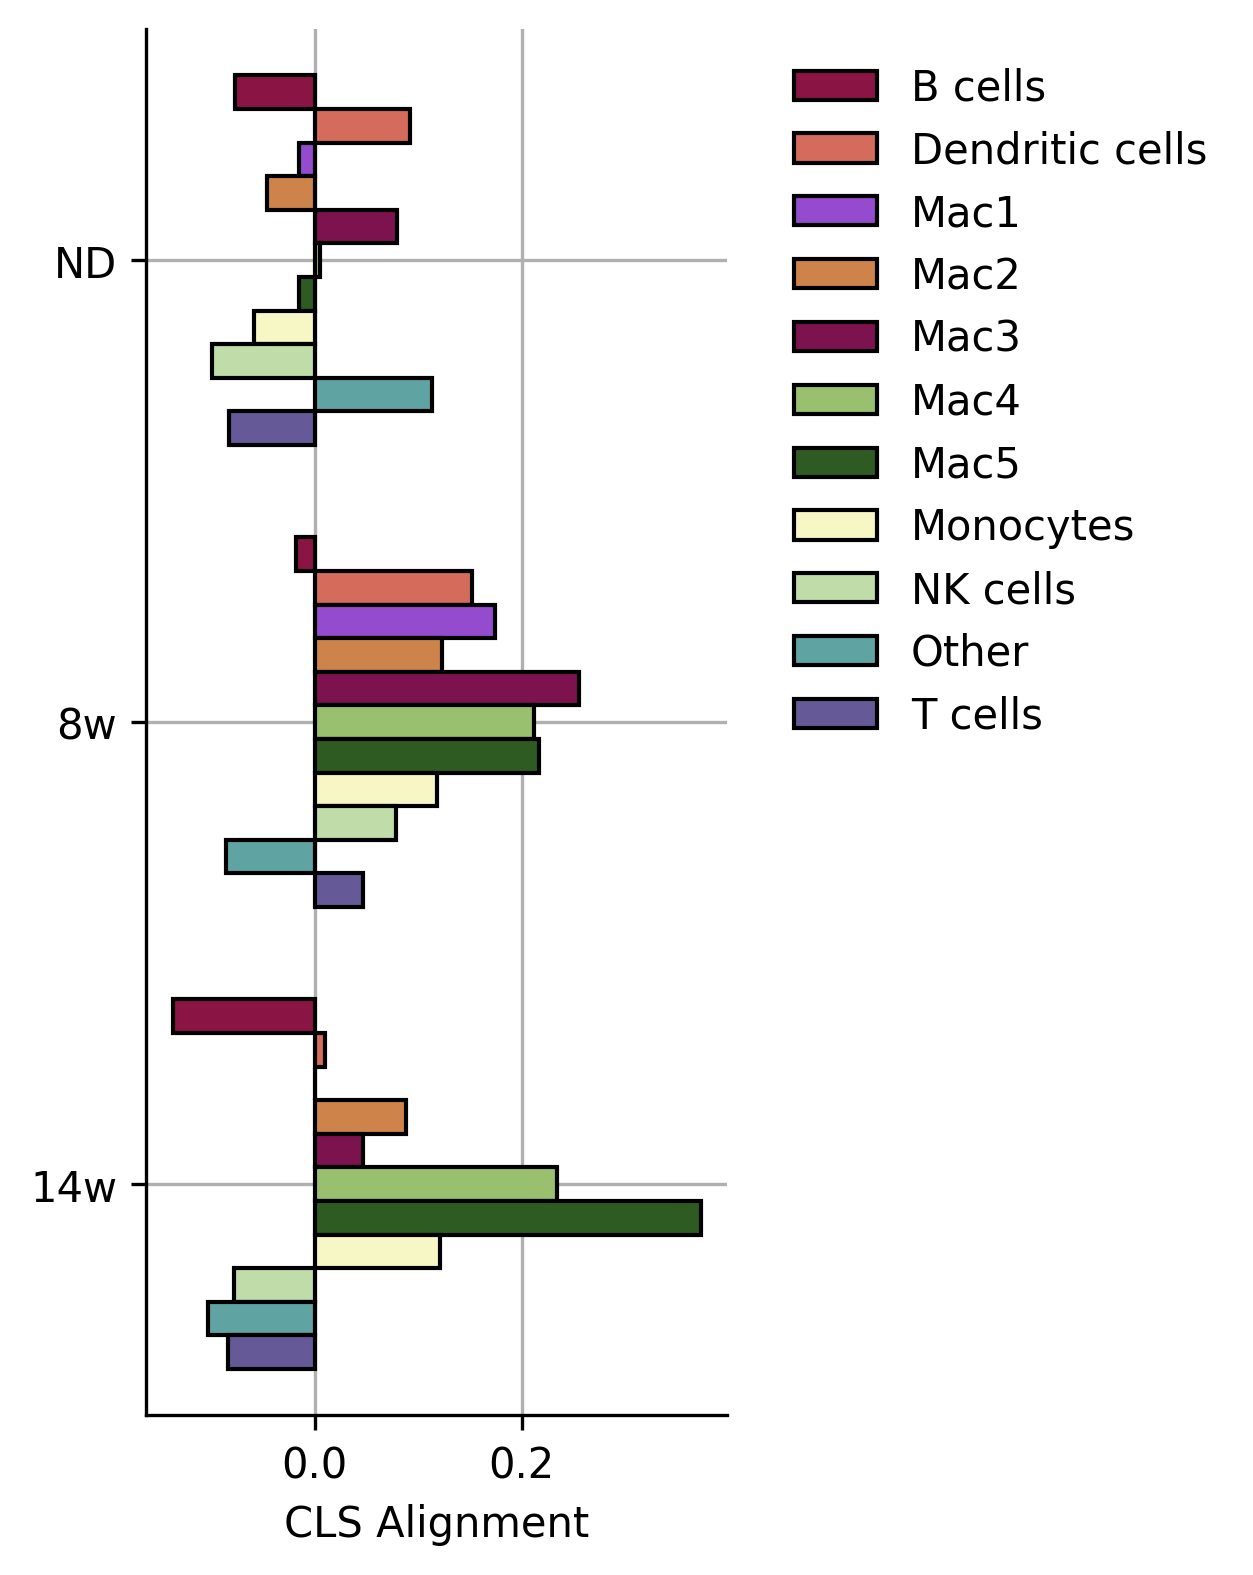

In [27]:
tol = 0.005
plotLabel = 1
alpha = 0.001

# ctypes = [
#     "T cells", 
#     "Monocytes",
#     "Mac4",
#     "Mac5",
# ]
ctypes = [
    'B cells',
    'Dendritic cells',
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
    'Monocytes',
    'NK cells',
    'Stromal cells',
    'T cells'
]

corr = []

for key in keys:
    print(key)
    G = allGraphs[key] # get the graph
    
    pdf = res[res['key'] == key][[1, 2, 3, 4, 'spotId']]
    pdf[plotLabel] = np.where(pdf[plotLabel] > np.quantile(pdf[plotLabel], 0.99), 0, pdf[plotLabel])

    node_attr = pdf.set_index('spotId').to_dict('index')
    segmentLabels = [node_attr[n][plotLabel] for n in G.nodes() if n in node_attr.keys()]
    
    for i, ct in enumerate(ctypes):    
        centrality = nx.eigenvector_centrality(G, weight=ct, tol=tol)
        centrality = [centrality[n] for n in G.nodes()]
        
        r, pval = scipy.stats.pearsonr(segmentLabels, centrality)
        
        row = {
            'key' : key,
            'cellType' : ct,
            "r" : r, 
            "pval" : pval
        }
        corr.append(row)

corr = pd.DataFrame(corr)
corr['sig'] = np.where(corr['pval'] < alpha, "*", "")
corr['keyName'] = corr['key'].map(keyMap)
corr['cellType'] = np.where(corr['cellType'] == 'Stromal cells', "Other", corr['cellType'])
corr = corr.sort_values(by=['key', 'cellType'], ascending=[False, True])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "None"
plt.rcParams['figure.figsize'] = 2.5, 6

colors = [
    '#9e0142', 
    '#e95c47', 
    # '#fdbf6f', 
    '#9835e4', 
    '#e48035', 
    '#8e0152', 
    '#9acd61', 
    '#276419',
    '#ffffbe',
    '#bfe5a0', 
    '#54aead',
    '#5e4fa2'
]

g = sns.barplot(data=corr, 
            y='keyName',
            x='r',
            zorder=3,
            edgecolor='k',
            palette=colors,
            hue='cellType')

# for j, p in enumerate(g.patches):
#     h, w, y = p.get_height(), p.get_width(), p.get_y()
#     print(h, w, h)
#     xy = (y + h / 2., w / 2)
#     rval = p.get_width()
#     s = corr.loc[corr['r'] == rval]['sig'].values[0]
#     r = corr.loc[corr['r'] == rval]['r'].values[0]
#     pad = 6
#     if r < 0:
#         pad = -6

#     g.annotate(s, xy)
#                # ha = 'center', 
#                # va = 'center', 
#                # xytext = (pad, 0), 
#                # textcoords = 'offset points')
        
plt.grid(True, zorder=0)
# plt.xlabel("Correlation with Centrality")
plt.xlabel("CLS Alignment")
plt.ylabel("")
sns.move_legend(plt.gca(), 
                title="",
                frameon=False,
                loc='upper left', 
                bbox_to_anchor=(1.05, 1))

plt.gca().set_facecolor('None')
sns.despine()

corr

In [ ]:
pdf = corr.copy()
outdir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/FIG6/"
fname = "correlations.csv"
pdf.to_csv(f"{outdir}{fname}", index=False)
pdf.head()

In [ ]:
ut.makeColorbar('Reds', 0.3, 2, "CLS$_{hi}$", "vertical", ['Low', "High"])

In [ ]:
handles = []

for r, c in zip(['Macrophages'], ["r"]):
    elem = Patch(color=c, 
                 ec='k', 
                 label=r)
    handles.append(elem)
    
plt.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots()
ax.legend(handles=handles, 
          loc='center', 
          ncols=4,
          frameon=False,)
             
plt.gca().axis(False)

In [ ]:
Mac